In [43]:
import pandas as pd #data analysis
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
df = pd.read_csv("Retail_Data_Transactions.csv") #import

#preview
df.head()

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


In [45]:
#Configure os folder
import os
# Create a folder for the pipeline step files
experiment_folder = r'C:\Users\SIMIYOUNG\Documents\Python-Projects\RFM\PyRFM\RFM'
os.makedirs(experiment_folder, exist_ok=True)

print(experiment_folder)

C:\Users\SIMIYOUNG\Documents\Python-Projects\RFM\PyRFM\RFM


In [46]:
#datatypes
df.dtypes

customer_id    object
trans_date     object
tran_amount     int64
dtype: object

In [47]:
#change date to date
df.trans_date = pd.to_datetime(df["trans_date"])

#data type
df.dtypes

customer_id            object
trans_date     datetime64[ns]
tran_amount             int64
dtype: object

In [48]:
#preview
df.head(2)

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39


### RFM
    - Recency

In [49]:
#Aggregate for the min and max date for each customer IDD
recency = df.groupby("customer_id").agg({'trans_date':['min', 'max']}).reset_index()

#drop levels on columns
recency.columns = recency.columns.droplevel()
    
#rename columns
recency.columns = ["ID", "Min", "Max"]

#preview
recency.head()

,ID,Min,Max
0,CS1112,2011-06-15,2015-01-14
1,CS1113,2011-05-27,2015-02-09
2,CS1114,2011-07-14,2015-02-12
3,CS1115,2011-08-10,2015-03-05
4,CS1116,2011-06-27,2014-08-25


In [50]:
df.dtypes

customer_id            object
trans_date     datetime64[ns]
tran_amount             int64
dtype: object

In [51]:
import datetime as dt
PRESENT = dt.datetime(2011,12,10)

In [52]:
df.groupby("customer_id").agg({"trans_date": lambda date: (date.max() - date.min()).days}).reset_index()

,customer_id,trans_date
0,CS1112,1309
1,CS1113,1354
2,CS1114,1309
3,CS1115,1303
4,CS1116,1155
...,...,...
6884,CS8996,1120
6885,CS8997,1116
6886,CS8998,1293
6887,CS8999,1073


In [53]:
type(df)

pandas.core.frame.DataFrame

In [54]:
df.trans_date.max()

Timestamp('2015-03-16 00:00:00')

In [55]:
present = dt.datetime(2015,3,17)

present

datetime.datetime(2015, 3, 17, 0, 0)

- Investigate how recency max date is actually calculated.  **
- See how classification is done
- Set list for segmentation for user customizability, also default to 4 segments with warning message.

- Note that for Recency Score we need to give inverse labels as the more active the customer is the lower the value of Recency. :)

- Customers with the lowest recency, highest frequency and monetary amounts considered as top customers.
    I don't think this is based on bins scores

#### How RFM Analysis Works

- Customers are assigned a recency score based on date of most recent purchase or time interval since most recent purchase. This score is based on a simple ranking of recency values into a small number of categories. For example, if you use five categories, the customers with the most recent purchase dates receive a recency ranking of 5, and those with purchase dates furthest in the past receive a recency ranking of 1.


- In a similar fashion, customers are then assigned a frequency ranking, with higher values representing a higher frequency of purchases. For example, in a five category ranking scheme, customers who purchase most often receive a frequency ranking of 5.


- Finally, customers are ranked by monetary value, with the highest monetary values receiving the highest ranking. Continuing the five-category example, customers who have spent the most would receive a monetary ranking of 5.

Simply put
    - The lower the recency score the better
    - The higher the frequency score the better
    - The higher the monetary score the better

In [56]:
#%%writefile $experiment_folder/recency.py
import pandas as pd

#define the function
def recency(data, id, date, present_date, bins = {5 : [5,4,3,2,1]}):
    '''
    This function will calculate the recency.
    data: Dataframe
        
        A dataframe containing at least the customer ID, Transaction/Order Date
    
    id:   String, Integer
        
        (Order/Customer/Transaction) Id column (string or int)
    
    date: Date, Datetime, Object

        A date column (NB: A type conversion will be attempted by the function but you can also ensure the date type is proper)
    threshold: An integer value, specifying how many days should be considered
    
    present_date: datetime 
        The present date or most recent date to serve as a reference point for recency
        
    bins: dictionary, default 5
        A dictionary containing the number of segments to be created from recency score and the labels associated 
        to quantile groups. NB: that for Recency Score we need to give inverse labels as the more active 
        the customer is the lower the value of Recency i
    '''
    #error instance to check if input is either a pandas dataframe and is also not none
    if isinstance(data, pd.DataFrame) == False or data is None:
        raise ValueError("data: Expecting a Dataframe or got 'None'")
    
    #error instance to check if id column is an identified column name
    if id not in data.columns:
        raise ValueError("id: Expected an id (a column) in Dataframe")
    
    #examine the datatype of the date column
    if data.dtypes[date].name not in ["datetime64[ns]", "datetime.datetime"]:
        raise ValueError("date: Expected a date datatype, 'convert the date/datetime type'")
        #print("This Column is not a of date/datetime data type")
    
    if present_date is None:
        raise ValueError("present_date: Specify the recent date to calculate recency")
    #aggregation to calculate recency
    result = data.groupby(id) \
            .agg({date: lambda date: (present_date - date.max()).days})\
            .reset_index() #reset index
    
    if isinstance(bins, dict) == False:
        raise ValueError("bin: Value needs to be an integer. default is 5")
    
    if len(list(bins.values())) != int(list(bins.keys())[0]):
        print("Warning: The number of bins for quantile is not same as the label. default is {}".format(bins))
    
    #rename column
    result.rename(columns = {date : "recency"}, inplace = True)
    
    #get bin value
    bin_value = int(list(bins.keys())[0])
    
    #get bin labels
    bin_labels = list(bins.values())[0]
    
    #logic to use bins value
    result["recency_bins"] = pd.qcut(result.recency, bin_value, bin_labels)
    
    #note that if bin changes then label needs to change also
    
    
    return result

In [57]:
#Bins tester
bins = {4: [4,3,2,1]}
#get bin value
bin_value = int(list(bins.keys())[0])
    
print(bin_value)
#get bin labels
bin_labels = list(bins.values())[0]
print(bin_labels)


4
[4, 3, 2, 1]


In [58]:
type(df)

pandas.core.frame.DataFrame

In [59]:
type(present)

datetime.datetime

In [60]:
#test recency function
recency(df, "customer_id", "trans_date", present, {6 : [6,5,4,3,2,1]})

#rec.recency_bins.value_counts()

,customer_id,recency,recency_bins
0,CS1112,62,3
1,CS1113,36,4
2,CS1114,33,4
3,CS1115,12,6
4,CS1116,204,1
...,...,...,...
6884,CS8996,98,2
6885,CS8997,262,1
6886,CS8998,85,3
6887,CS8999,258,1


In [61]:
df.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


#### Frequency

In [62]:
#%%writefile $experiment_folder/frequency.py

#pandas module
import pandas as pd

#define function
def frequency(data, id, bins = {5 : [1,2,3,4,5]}):
    '''
    This function will calculate the recency.
    data: Dataframe
        
        A dataframe containing at least the customer ID, Transaction/Order Date
    
    id:   String, Integer
        
        (Order/Customer/Transaction) Id column (string or int)
        
    bins: dictionary, default 5
        A dictionary containing the number of segments to be created from recency score and the labels associated 
        to quantile groups. The higher the frequency score the more top priority the customer
    '''
    #error instance to check if input is either a pandas dataframe and is also not none
    if isinstance(data, pd.DataFrame) == False or data is None:
        raise ValueError("data: Expecting a Dataframe or got 'None'")
    
    #error instance to check if id column is an identified column name
    if id not in data.columns:
        raise ValueError("id: Expected an id (a column) in Dataframe")
    
    #if bin is not a dictionary, raise error
    if isinstance(bins, dict) == False:
        raise ValueError("bin: Value needs to be an integer. default is 5")
        
    #check if the size of the quartile split is the same as  the labels provided
    if len(list(bins.values())) != int(list(bins.keys())[0]):
        print("Warning: The number of bins for quantile is not same as the label. default is {}".format(bins))
    
    
    #examine the datatype of the date column
    #aggregation to calculate recency
    result = pd.DataFrame(data.groupby(id).size()).reset_index()
    
    #rename size column to frequency
    result.rename(columns = {0 : "frequency"}, inplace = True)
    
    #get bin value from dict
    bin_value = int(list(bins.keys())[0])
    
    #get bin labels from dict
    bin_labels = list(bins.values())[0]
    
    #logic to use bins value
    result["frequency_bins"] = pd.qcut(result.frequency, bin_value, bin_labels)
    #rename column
    
    
    
    return result

In [63]:
#test function
(frequency(df, "customer_id")).frequency_bins.value_counts()

1    1743
4    1686
2    1388
5    1070
3    1002
Name: frequency_bins, dtype: int64

In [64]:
#%%writefile $experiment_folder/monetary.py

#pandas module
import pandas as pd

#define function
def monetary(data, id, spend, bins = {5 : [1,2,3,4,5]}):
    '''
    This function will calculate the recency.
    data: Dataframe
        
        A dataframe containing at least the customer ID, Transaction/Order Date
    
    id:   String, Integer
        
        (Order/Customer/Transaction) Id column (string or int)
        
    spend: int or float
        
        The cost column either transaction cost
        
    bins: dictionary
        A dictionary containing the number of segments to be created from recency score and the labels associated 
        to quantile groups. The higher the monetary label the more top priority the customer
    '''
    #error instance to check if input is either a pandas dataframe and is also not none
    if isinstance(data, pd.DataFrame) == False or data is None:
        raise ValueError("data: Expecting a Dataframe or got 'None'")
    
    #error instance to check if id column is an identified column name
    if id not in data.columns or spend not in data.columns:
        raise ValueError("id/spend: Expected an id/spend (a column name) in 'Dataframe'")
    
    #if bin is not a dictionary, raise error
    if isinstance(bins, dict) == False:
        raise ValueError("bin: Value needs to be an integer. default is 5")
        
    #check if the size of the quartile split is the same as  the labels provided
    if len(list(bins.values())) != int(list(bins.keys())[0]):
        print("Warning: The number of bins for quantile is not same as the label. default is {}".format(bins))
    
    #examine the datatype of the date column
    #aggregation to calculate recency
    result = pd.DataFrame(data.groupby(id)[spend].sum()).reset_index()

    #rename column
    result.rename(columns = {spend : "monetary"}, inplace = True)
    
     #get bin value from dict
    bin_value = int(list(bins.keys())[0])
    
    #get bin labels from dict
    bin_labels = list(bins.values())[0]
    
    #logic to use bins value
    result["monetary_bins"] = pd.qcut(result.monetary, bin_value, bin_labels)
    #rename column
    
    
    return result

In [65]:
df.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [66]:
#test monetary
monetary(df, "customer_id", "tran_amount")

,customer_id,monetary,monetary_bins
0,CS1112,1012,2
1,CS1113,1490,4
2,CS1114,1432,4
3,CS1115,1659,5
4,CS1116,857,2
...,...,...,...
6884,CS8996,582,1
6885,CS8997,543,1
6886,CS8998,624,1
6887,CS8999,383,1


- Define complete RFM function

In [67]:
#%%writefile $experiment_folder/rfm.py

##pandas module
import pandas as pd


def rfm(data, id, date, present_date, spend, bins = {5 : [5,4,3,2,1]}):
    '''
    This function will calculate the recency.
    data: Dataframe
        
        A dataframe containing at least the customer ID, Transaction/Order Date
    
    id:   String, Integer
        
        (Order/Customer/Transaction) Id column (string or int)
    
    date: Date, Datetime, Object

        A date column (NB: A type conversion will be attempted by the function but you can also ensure the date type is proper)
    threshold: An integer value, specifying how many days should be considered
    
    present_date: datetime 
        The present date or most recent date to serve as a reference point for recency
        
    bins: dictionary, default 5
        A dictionary containing the number of segments to be created from recency score and the labels associated 
        to quantile groups. NB: that for Recency Score we need to give inverse labels as the more active 
        the customer is the lower the value of Recency i
    '''
    #error instance to check if input is either a pandas dataframe and is also not none
    if isinstance(data, pd.DataFrame) == False or data is None:
        raise ValueError("data: Expecting a Dataframe or got 'None'")
    
    #error instance to check if id column is an identified column name
    if id not in data.columns:
        raise ValueError("id: Expected an id (a column) in Dataframe")
    
    #examine the datatype of the date column
    if data.dtypes[date].name != "datetime64[ns]":
        raise ValueError("date: Expected a date datatype, 'convert the date/datetime type'")
        #print("This Column is not a of date/datetime data type")
    
    if present_date is None:
        raise ValueError("present_date: Specify the recent date to calculate recency")
    #aggregation to calculate recency
    result = data.groupby(id) \
            .agg({date: lambda date: (present_date - date.max()).days})\
            .reset_index() #reset index
    
    if isinstance(bins, dict) == False:
        raise ValueError("bin: Value needs to be an integer. default is 5")
    
    if len(list(bins.values())) != int(list(bins.keys())[0]):
        print("Warning: The number of bins for quantile is not same as the label. default is {}".format(bins))
    
    
    #recency
    a = recency(data = data, id = id, date = date, present_date = present_date, bins = bins)
    
    #frequency 
    #drop id column
    b = frequency(data = data, id = id, bins = bins).drop(id, axis = 1)
    
    #monetary
    #drop id column
    c = monetary(data = data, id = id, spend = spend, bins = bins).drop(id, axis = 1)
    
    #append results
    result = pd.concat([a, b, c], axis = 1)
    
    #add rfm column
    #concatenate rfm columns individual bin values to get the final rating of each customer
    result["RFM"] = result.recency_bins.astype(str) + result.frequency_bins.astype(str) + result.monetary_bins.astype(str)
    
    return result
    

In [68]:
#apply rfm function
customer = rfm(data = df, id = "customer_id", date = "trans_date", 
    present_date = present, spend = "tran_amount", bins = {5 : [5,4,3,2,1]})

In [69]:
#preview
customer.RFM.value_counts().sort_values(ascending = False)

155    428
511    286
522    267
411    246
255    238
      ... 
542      1
314      1
214      1
431      1
113      1
Name: RFM, Length: 89, dtype: int64

In [70]:
customer[customer.RFM == '155']

,customer_id,recency,recency_bins,frequency,frequency_bins,monetary,monetary_bins,RFM
409,CS1521,195,1,9,5,671,5,155
418,CS1530,252,1,10,5,626,5,155
604,CS1716,353,1,6,5,440,5,155
803,CS1915,183,1,6,5,497,5,155
921,CS2033,198,1,9,5,571,5,155
...,...,...,...,...,...,...,...,...
6873,CS8985,227,1,12,5,502,5,155
6876,CS8988,249,1,14,5,552,5,155
6880,CS8992,170,1,9,5,277,5,155
6885,CS8997,262,1,14,5,543,5,155


In [71]:
customer.groupby('RFM')["monetary"].sum().sort_values(ascending = False)

RFM
511    535050
411    455518
311    396655
522    393005
322    317832
        ...  
535      1246
113      1145
214      1069
514      1026
314      1020
Name: monetary, Length: 89, dtype: int64

In [72]:
import numpy as np
customer.groupby('RFM').agg({"monetary": [np.mean, np.sum]})

monetary        
            mean     sum
RFM                     
111  1852.688889  166742
112  1530.285714   10712
113  1145.000000    1145
121  1654.926829   67852
122  1465.625899  203722
..           ...     ...
544   921.100775  118822
545   623.891892   23084
553  1126.000000    5630
554   890.919540   77510
555   509.716049   82574

[89 rows x 2 columns]

In [73]:
test = pd.read_csv("https://raw.githubusercontent.com/simmieyungie/Bakery-Analytics/master/transactionsAHW.csv")

test.head()

,OnlineOrderFlag,CustomerID,Name,ProductSubName,ProductCatName,OrderQty,OrderDate
0,True,11000,Fender Set - Mountain,Fenders,Accessories,1,2013-06-20
1,True,11000,"Mountain-100 Silver, 38",Mountain Bikes,Bikes,1,2011-06-21
2,True,11000,Touring Tire Tube,Tires and Tubes,Accessories,1,2013-10-03
3,True,11000,"Mountain-200 Silver, 38",Mountain Bikes,Bikes,1,2013-06-20
4,True,11000,"Sport-100 Helmet, Red",Helmets,Accessories,1,2013-10-03


In [74]:
df.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


<AxesSubplot:>

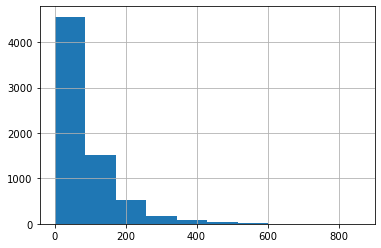

In [75]:
customer.recency.hist()

<AxesSubplot:>

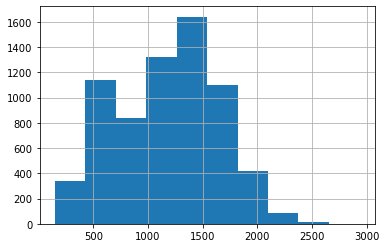

In [76]:
customer.monetary.hist()

<AxesSubplot:>

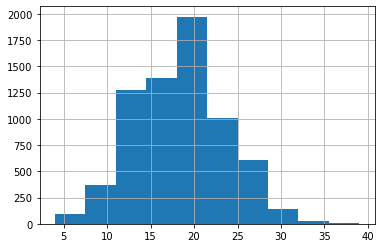

In [77]:
customer.frequency.hist()

In [80]:
customer.head()

,customer_id,recency,recency_bins,frequency,frequency_bins,monetary,monetary_bins,RFM
0,CS1112,62,3,15,4,1012,4,344
1,CS1113,36,4,20,2,1490,2,422
2,CS1114,33,4,19,3,1432,2,432
3,CS1115,12,5,22,2,1659,1,521
4,CS1116,204,1,13,5,857,4,154


In [113]:
#%%writefile $experiment_folder/plot_rfm_hist.py

#RFM histogram
import matplotlib.pyplot as plt


def plot_rfm_hist(rfm_table):
    '''
    This function will return a histogram distribution of rfm values.
    rfm_table: Dataframe
        
        A dataframe containing at least recency, frequency and monetary columns. It's to be used
        particularly after using the rfm function
    '''
      #error instance to check if input is either a pandas dataframe and is also not none
    if isinstance(rfm_table, pd.DataFrame) == False or rfm_table is None:
        raise ValueError("data: Expecting a Dataframe or got 'None'")
        
    if "recency" not in rfm_table.columns:
        raise ValueError("recency: recency column not found in column names, add 'recency'")
        
    if "frequency" not in rfm_table.columns:
        raise ValueError("frequency: recency column not found in column names, add 'frequency'")
        
    if "monetary" not in rfm_table.columns:
        raise ValueError("monetary: recency column not found in column names, add 'monetary'")
        
    fig, ax = plt.subplots(1,3, figsize = (10, 5)) #one row, three columns
    #recency
    ax[0].hist(rfm_table.recency)
    ax[0].set_title("Recency")
    #frequency
    ax[1].hist(rfm_table.frequency)
    ax[1].set_title("Frequency")
    #monetary
    ax[2].hist(rfm_table.monetary)
    ax[2].set_title("Monetary")
    plt.show()
    
    return 

Writing C:\Users\SIMIYOUNG\Documents\Python-Projects\RFM\PyRFM\RFM/plot_rfm_hist.py


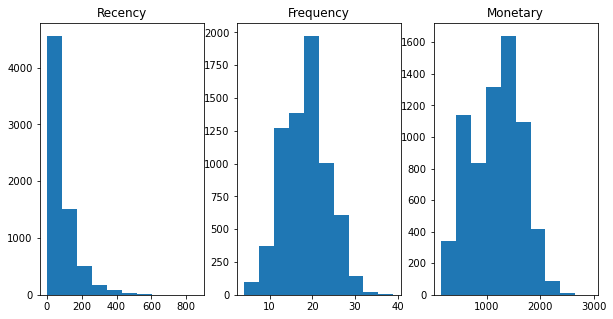

In [111]:
plot_rfm_hist(customer)

### Thoughts
    - See if we can fit groups using Kmeans instead of quartile for each
    - Fit a customer segmentation model using result of rfm bins (theoricize)
    - Pareto Analysis for customers
    - Heatmap for recency vs freq vs mone

In [78]:
#Pareto
